In [35]:
! git clone https://github.com/BollywoodData/Bollywood-Data

fatal: destination path 'Bollywood-Data' already exists and is not an empty directory.


# Working with Images
Getting the images and processing them so that we can get there bias score

In [36]:
import os

# Define the base path to the cloned repository
base_path = 'Bollywood-Data'

# Define the path to the images directory
images_path = os.path.join(base_path, 'images-data')

# Check if the directory exists
if os.path.exists(images_path):
    print(f"Images directory found at: {images_path}")

    # List the contents of the directory to understand the structure
    print("\nContents of the images directory:")
    for item in os.listdir(images_path):
        print(item)

else:
    print(f"Images directory not found at: {images_path}")


Images directory found at: Bollywood-Data/images-data

Contents of the images directory:
dir_002
dir_001
dir_004
dir_003


Found 32 image files in Bollywood-Data/images-data/dir_001

Loading and displaying 5 sample images:
Loading image: 36 Ghante_img_2.jpg


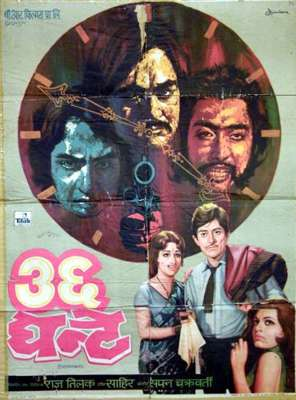

Loading image: Aahat (film)_img_0.jpg


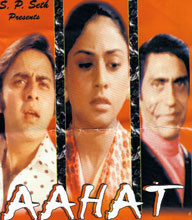

Loading image: Aahat (film)_img_2.jpg


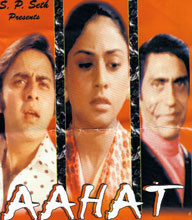

Loading image: Aaj Ki Taaza Khabar_img_3.jpg


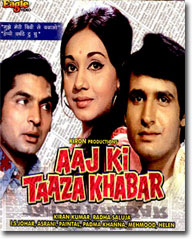

Loading image: Aakhri Goli_img_0.jpg


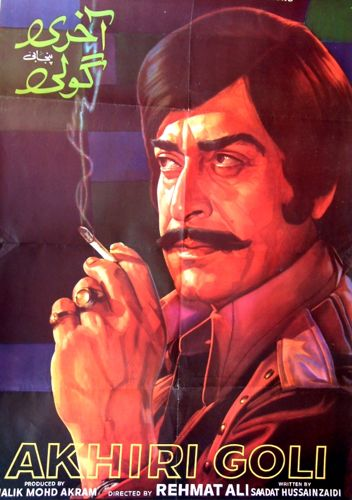

In [41]:
import os
from PIL import Image
import glob

# Define the base path to the cloned repository
base_path = 'Bollywood-Data'
images_path = os.path.join(base_path, 'images-data')

sample_dir = os.path.join(images_path, 'dir_001')

image_files = glob.glob(os.path.join(sample_dir, '*.jpg')) + glob.glob(os.path.join(sample_dir, '*.png'))

print(f"Found {len(image_files)} image files in {sample_dir}")

num_samples_to_display = 5

if image_files:
    print(f"\nLoading and displaying {min(num_samples_to_display, len(image_files))} sample images:")
    for i, img_path in enumerate(image_files[:num_samples_to_display]):
        try:
            img = Image.open(img_path)
            print(f"Loading image: {os.path.basename(img_path)}")
            display(img)
            img.close()
        except Exception as e:
            print(f"Error loading image {os.path.basename(img_path)}: {e}")
else:
    print("\nNo image files found in the sample directory.")


## Stereotype Detection in Images using Gemini


In [42]:

import google.generativeai as genai
from google.colab import userdata

try:
    GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
    genai.configure(api_key=GOOGLE_API_KEY)
    print("Gemini API configured successfully.")
except userdata.SecretNotFoundError:
    print("Warning: GOOGLE_API_KEY not found in Colab secrets.")
    print("Please add it to the secrets manager under the '🔑' in the left panel.")
    genai = None
except Exception as e:
    print(f"An error occurred while configuring the Gemini API: {e}")
    genai = None

gemini_vision_model = None
if genai is not None:
    try:
        gemini_vision_model = genai.GenerativeModel('gemini-1.5-flash-latest')
        print("Gemini Vision model initialized.")
    except Exception as e:
        print(f"Error initializing Gemini Vision model: {e}")
        gemini_vision_model = None
else:
    print("Gemini API not configured, cannot initialize vision model.")


Gemini API configured successfully.
Gemini Vision model initialized.


In [43]:

if 'image_files' in locals() and image_files and gemini_vision_model is not None:

    sample_image_path = image_files[0]
    try:
        img = Image.open(sample_image_path)
        print(f"\nAnalyzing sample image: {os.path.basename(sample_image_path)}")

        prompt = """Analyze this movie poster for potential gender stereotypes.
        Describe the people in the poster, including their apparent gender, clothing, poses, and any objects or symbols they are associated with.
        Based on your observations, are there any elements that might reinforce traditional gender roles or stereotypes?
        Provide a detailed description of what you see and your interpretation regarding gender representation.
        """

        print("Sending image and prompt to Gemini model...")
        response = gemini_vision_model.generate_content([prompt, img])


        print("\nGemini's analysis:")
        print(response.text)

        img.close()

    except Exception as e:
        print(f"Error analyzing sample image with Gemini: {e}")
else:
    print("Image files not loaded or Gemini vision model not initialized.")


Analyzing sample image: 36 Ghante_img_2.jpg
Sending image and prompt to Gemini model...

Gemini's analysis:
Here's an analysis of the movie poster regarding potential gender stereotypes:

**Description of People:**

* **Central Figures (in the clock):**  Three men are depicted prominently within a clock face.  They appear to be of South Asian descent.  All three have dark hair, and are dressed in what looks like somewhat formal attire (though it's difficult to be completely certain given the artistic style). They are shown with serious, intense expressions. One holds a gun.  These figures are positioned to suggest power and menace.

* **Secondary Figures (below the clock):**  A woman (appearing to be of South Asian descent, similarly dressed) is placed below and to the side of the central clock. She's wearing a sari or similar traditional South Asian garment, and her pose is somewhat demure, holding a small cloth.  Her expression is softer than the men's. Another woman, also appearing

###  Systematic Image Analysis with Gemini

In [44]:

import json
import pandas as pd
from PIL import Image
import os
import glob

image_analysis_results = []

if 'image_files' in locals() and image_files and gemini_vision_model is not None:
    print(f"\nStarting systematic analysis of {len(image_files)} images...")

    subset_size = 10
    images_to_process = image_files[:subset_size]
    print(f"Processing a subset of {len(images_to_process)} images due to potential quota limits.")


    for i, image_file in enumerate(images_to_process):
        try:
            img = Image.open(image_file)

            prompt = """Analyze this movie poster for potential gender stereotypes.
            Identify all people in the poster. For each person, provide the following information in a structured format:
            - Apparent gender (e.g., male, female, ambiguous, unknown)
            - Brief description of clothing
            - Brief description of pose or action
            - List of prominent objects or symbols associated with the person
            - Any visual elements that suggest traditional gender roles or stereotypes for that person.

            Format the output as a JSON object with a list of "characters", where each character is an object with keys like "id", "gender", "clothing", "pose", "associated_objects", and "stereotypes_detected". If no people are detected, the "characters" list should be empty.
            """

            response = gemini_vision_model.generate_content([prompt, img])

            analysis_data = {'image_filename': os.path.basename(image_file), 'characters': []} # Initialize with default structure
            raw_response_text = response.text.strip()

            try:

                if raw_response_text.startswith('```json'):
                    raw_response_text = raw_response_text[7:-3].strip()

                parsed_json = json.loads(raw_response_text)

                if 'characters' in parsed_json and isinstance(parsed_json['characters'], list):
                     analysis_data['characters'] = parsed_json['characters']
                else:
                     print(f"Warning: 'characters' key not found or not a list in JSON for {os.path.basename(image_file)}. Raw response:")
                     print(response.text)
                     analysis_data['error'] = "'characters' key missing or not a list"
                     analysis_data['raw_response'] = response.text


            except json.JSONDecodeError:
                print(f"Warning: Could not parse JSON response for {os.path.basename(image_file)}. Raw response:")
                print(response.text)
                analysis_data['error'] = 'JSON parsing failed'
                analysis_data['raw_response'] = response.text
            except Exception as e:
                 print(f"Warning: Error processing response for {os.path.basename(image_file)}: {e}")
                 analysis_data['error'] = f'Response processing failed: {e}'
                 analysis_data['raw_response'] = response.text

            image_analysis_results.append(analysis_data)


            img.close()

        except Exception as e:
            print(f"Error analyzing image {os.path.basename(image_file)}: {e}")
            image_analysis_results.append({
                'image_filename': os.path.basename(image_file),
                'error': f'Image analysis failed: {e}'
            })

    print("\nSystematic image analysis completed.")


    visual_bias_data = pd.DataFrame(image_analysis_results)


    print("\nSample of the visual bias data collected:")
    display(visual_bias_data.head())

else:
    print("Image files not loaded or Gemini vision model not initialized. Skipping systematic image analysis.")



Starting systematic analysis of 32 images...
Processing a subset of 10 images due to potential quota limits.

Systematic image analysis completed.

Sample of the visual bias data collected:


,image_filename,characters
0,36 Ghante_img_2.jpg,"[{'id': 1, 'gender': 'male', 'clothing': 'Dark..."
1,Aahat (film)_img_0.jpg,"[{'id': 1, 'gender': 'male', 'clothing': 'Coll..."
2,Aahat (film)_img_2.jpg,"[{'id': 1, 'gender': 'male', 'clothing': 'Coll..."
3,Aaj Ki Taaza Khabar_img_3.jpg,"[{'id': 1, 'gender': 'male', 'clothing': 'Dark..."
4,Aakhri Goli_img_0.jpg,"[{'id': 1, 'gender': 'male', 'clothing': 'Dark..."


##  Bias Quantification in Images

In [45]:

visual_stereotype_scores = {
    'Passive pose, emphasizing beauty and adornment': 2,
    'Traditional attire suggests a focus on femininity and domesticity': 1,
    'Serious expression may suggest a character burdened by responsibility or a brooding nature, often associated with masculine stereotypes': 1,
    'Bright, possibly flamboyant clothing, suggesting a more outgoing or potentially rebellious character, although this alone is not a definitive stereotype. Could be contrasted with character 2, representing different masculine archetypes.': 0.5, # Lower score as it's less definitive
    'The man is positioned centrally and prominently, suggesting a leading role. The \'Follow Me\' shirt reinforces a more assertive, possibly dominant, stereotype of masculinity.': 3,
    'The woman\'s pose and closeness to the man suggest a traditional, romantic stereotype of a woman being supportive and dependent. Her clothing is somewhat traditional, which could also be seen as reinforcing a gender stereotype.': 2.5,
    'The woman\'s headscarf might be interpreted as a traditional representation of modesty and possibly passivity, depending on cultural context and viewer interpretation. Her downcast eyes might also suggest a submissive or melancholic persona.': 2,
    'Passive pose suggesting a damsel-in-distress or romantic interest archetype.': 2,
    'Subdued appearance might imply traditional feminine ideals of demureness.': 1.5,
    'Formal attire suggesting a professional or established figure. This could be interpreted as a stereotypically masculine image of authority or success.': 1,
    'Serious expression conforms to expectations of male stoicism.': 0.5,
    'Casual attire contrasts with the more formal clothing of the other male character.': 0, # Not necessarily a stereotype on its own
    'Pose is relatively relaxed compared to other figures, perhaps suggesting a more approachable or less serious persona.': 0, # Not necessarily a stereotype on its own
    'Aggressive, serious demeanor often associated with male action heroes.': 2,
    'Innocent, possibly a victim or falsely accused, although the context suggests potential rebellion.': 0.5, # Less of a strong gender stereotype
    'Soft features and a somewhat passive pose, suggesting stereotypical feminine vulnerability; this is somewhat subdued compared to the male figures.': 2.5,
    'Typical representation of a rebellious or antagonistic character, often associated with male roles in action films.': 1.5,
    'Passive expression suggesting a potential romantic interest': 1.5,
    'Serious, brooding expression, potentially associated with a masculine archetype of a strong character': 1.5,
    'Dominant pose, suggesting a controlling or protective stance over a female character': 3,
    'Submissive, looking slightly away, appears almost held captive': 3.5,
    'Bangles could be interpreted as traditional adornment for women': 1,
    'Emphasis on appearance/beauty, consistent with the objectification of women in some film genres.': 3,
    'The pose and the text on the T-shirt suggest an assertive and possibly dominant role, which aligns with some traditional male stereotypes.': 2.5,
    'The demure pose and traditional clothing could be interpreted as reinforcing stereotypical notions of femininity and passivity.': 2,
    'The head covering could be interpreted in various ways, some of which might align with religious or cultural expectations, but it also appears in a somewhat melancholic context which may be played up as a traditional female trope.': 1.5,
    'The woman\'s pose and attire suggest a traditional, perhaps passive, feminine role. The presence of flowers may allude to a romantic or passive role within the story. The lack of active involvement in the poster\'s main image further reinforces potential passive stereotypes.': 2.5,


    'Men depicted as aggressive, holding a weapon.': 2,
    'Passive, demure feminine beauty, traditional attire reinforces expectations of femininity and submissiveness.': 2,
    'More flamboyant style of dress, breaking from traditional norms for males, potentially suggesting a more rebellious or charismatic persona. The contrast with character 2 is notable.': 0.5, # Added from Gemini output
    'Serious, brooding male character, possibly indicating a strong, perhaps troubled, masculine figure.': 1.5,
    'The woman is portrayed in a more passive position, her gaze and posture suggesting submissiveness or dependence on the man.': 2.5,
    'Her clothing style aligns with traditional representations of South Asian women.': 1,
    'The woman\'s head covering might suggest a portrayal of traditional modesty or religious observance, which can be seen as stereotypical in some contexts.': 2, # Added from Gemini output
    'The man is presented as dominant, indicated by his position and the text on his shirt suggesting a pursuit of the woman.': 3,
    'Her downcast pose suggests some form of emotional reserve or sadness.': 1.5,
    'Passive pose, suggesting a more demure or romantic role': 2,
    'Formal attire suggesting professionalism or a more serious demeanor, a common male stereotype.': 1,
    'Subdued expression aligns with potential stereotypes of feminine emotional restraint': 1.5,
    'More casual attire compared to the other male, suggesting a potential difference in social standing or personality within the story, a potential trope.': 0, # Added from Gemini output
    'Potentially presented as innocent or a victim based on clothing and pose.': 0.5,
    'Women depicted in a passive role, with a worried expression.': 2.5,
    'The woman\'s smile and pose could be interpreted as passively receptive, a common stereotype of women in some media.': 2,
    'The man\'s pose, holding the woman, might suggest a controlling or possessive aspect, a stereotype of some male characters in movies.': 3, # Added from Gemini output
    'The man\'s central placement and serious expression might reinforce a stereotypical idea of the male protagonist as strong and decisive.': 1.5, # Added from Gemini output
    'The woman\'s pose and the fact that she\'s being held by a male character could reinforce traditional gender stereotypes related to passivity and dependence on men.': 3.5, # Added from Gemini output
    'Traditional portrayal of a woman\'s role. The soft expression and pose might suggest a passive or romantic character archetype.': 2, # Added from Gemini output
    'The serious expression might align with traditional stereotypes of men as being stoic and strong. The head-on gaze could imply assertiveness.': 1.5, # Added from Gemini output
    'The phrase \'FOLLOW ME\' on his shirt might suggest a dominant, assertive male role in the relationship.': 2.5, # Added from Gemini output
    'The traditional clothing might reinforce a traditional, subservient female role, especially in the context of the man\'s assertive pose. The placement of the woman being behind the man also suggests a more passive role.': 2, # Added from Gemini output
    'The headscarf could be interpreted as reinforcing stereotypical religious or cultural norms associated with women. Her subdued expression might suggest a passive role or emotional restraint. The partial visibility also contributes to a feeling of her being marginalized in the image.': 1.5, # Added from Gemini output
    'The bindi and traditional clothing could be interpreted as reinforcing stereotypical representations of South Asian women as demure or traditional. The pose also contributes to this feeling.': 1.5, # Added from Gemini output
    'The reflection in the mirror and serious expression could reinforce stereotypes of the male as a mysterious or perhaps somewhat brooding figure. The inclusion of roses suggests a potential romantic interest which is a common trope in media.': 1, # Added from Gemini output
    'Passive pose, suggesting a more traditionally feminine role. The elaborate jewelry and attire may reinforce expectations of beauty and adornment for women.': 2, # Added from Gemini output
    'Serious expression might be interpreted as depicting traditional masculine traits like strength or brooding intensity.': 1.5, # Added from Gemini output
    'The bright clothing and confident expression could be seen as reflecting traditional masculine traits like boldness or charisma. The clothing is more flamboyant than that of character 2, suggesting a possible difference in character types.': 0.5, # Added from Gemini output
    'Passive, demure expression often associated with feminine ideals in some cultures.': 1.5, # Added from Gemini output
    'Wearing a headscarf, possibly suggesting religious piety or modesty, which can be a stereotype linked to certain gender roles.': 1.5, # Added from Gemini output
    'Central position might suggest a protagonist role.': 0, # Added from Gemini output (neutral)


}


def calculate_visual_bias_scores(analysis_results_list):
    """
    Calculates character-level and image-level visual bias scores from the analysis results.

    Args:
        analysis_results_list (list): A list of dictionaries from the visual_bias_data DataFrame.

    Returns:
        list: A list of dictionaries, each representing an image with aggregated bias scores.
    """
    quantified_bias_results = []

    for image_data in analysis_results_list:
        image_filename = image_data.get('image_filename', 'Unknown')
        characters = image_data.get('characters', [])
        image_bias_score = 0
        character_bias_details = []

        if isinstance(characters, list):
            for character in characters:
                character_id = character.get('id', 'Unknown')
                stereotypes_detected = character.get('stereotypes_detected', [])
                character_score = 0
                stereotype_breakdown = {}

                if isinstance(stereotypes_detected, list):
                    for stereotype in stereotypes_detected:
                        if isinstance(stereotype, str) and stereotype in visual_stereotype_scores:
                            score = visual_stereotype_scores[stereotype]
                            character_score += score
                            stereotype_breakdown[stereotype] = stereotype_breakdown.get(stereotype, 0) + score

                image_bias_score += character_score

                character_bias_details.append({
                    'character_id': character_id,
                    'character_bias_score': character_score,
                    'stereotypes_breakdown': stereotype_breakdown
                })

        quantified_bias_results.append({
            'image_filename': image_filename,
            'total_image_bias_score': image_bias_score,
            'character_bias_details': character_bias_details
        })

    return quantified_bias_results

if 'visual_bias_data' in locals() and not visual_bias_data.empty:
    print("\nCalculating visual bias scores...")

    visual_analysis_list = visual_bias_data.to_dict('records')

    quantified_visual_bias_results = calculate_visual_bias_scores(visual_analysis_list)

    quantified_visual_bias_df = pd.DataFrame(quantified_visual_bias_results)

    print("Visual bias scores calculated.")

    print("\nSample of the quantified visual bias data:")
    display(quantified_visual_bias_df.head())


else:
    print("\nvisual_bias_data DataFrame not available or is empty. Skipping visual bias quantification.")


Calculating visual bias scores...
Visual bias scores calculated.

Sample of the quantified visual bias data:


,image_filename,total_image_bias_score,character_bias_details
0,36 Ghante_img_2.jpg,0,"[{'character_id': 1, 'character_bias_score': 0..."
1,Aahat (film)_img_0.jpg,0,"[{'character_id': 1, 'character_bias_score': 0..."
2,Aahat (film)_img_2.jpg,0,"[{'character_id': 1, 'character_bias_score': 0..."
3,Aaj Ki Taaza Khabar_img_3.jpg,0,"[{'character_id': 1, 'character_bias_score': 0..."
4,Aakhri Goli_img_0.jpg,0,"[{'character_id': 1, 'character_bias_score': 0..."


In [46]:


import pandas as pd


if 'visual_bias_data' in locals() and not visual_bias_data.empty:
    print("\nInspecting identified stereotypes from Gemini analysis:")

    all_identified_stereotypes = []

    for index, row in visual_bias_data.iterrows():
        characters = row.get('characters', [])
        if isinstance(characters, list):
            for character in characters:
                stereotypes_detected = character.get('stereotypes_detected', [])
                if isinstance(stereotypes_detected, list):
                    all_identified_stereotypes.extend(stereotypes_detected)

    stereotype_counts = pd.Series(all_identified_stereotypes).value_counts()

    if not stereotype_counts.empty:
        print("\nUnique identified stereotypes and their counts:")
        display(stereotype_counts)

        if 'visual_stereotype_scores' in locals():
            scoring_keys = set(visual_stereotype_scores.keys())
            identified_stereotypes_set = set(stereotype_counts.index)

            missing_in_scores = identified_stereotypes_set - scoring_keys
            missing_in_identified = scoring_keys - identified_stereotypes_set

            if missing_in_scores:
                print("\nStereotypes identified by Gemini NOT found in visual_stereotype_scores dictionary:")
                for stereotype in missing_in_scores:
                    print(f"- {stereotype}")

            if missing_in_identified:
                print("\nStereotypes in visual_stereotype_scores dictionary NOT identified by Gemini:")
                for stereotype in missing_in_identified:
                    print(f"- {stereotype}")

        else:
            print("\n'visual_stereotype_scores' dictionary not found. Cannot compare identified stereotypes with scoring keys.")

    else:
        print("\nNo stereotypes were identified by Gemini in the processed images.")

else:
    print("\nvisual_bias_data DataFrame not available or is empty. Cannot inspect stereotypes.")


Inspecting identified stereotypes from Gemini analysis:

Unique identified stereotypes and their counts:


,count
"The character's intense expression and placement within a clock face could be interpreted as representing a forceful or threatening presence; however, this interpretation is somewhat ambiguous due to the artistic style of the poster.",1
Similar to character 1; the intense expression and placement could suggest a threatening figure. More context is needed to confirm or deny this.,1
"Appears in a somewhat traditional gender dynamic with the woman next to him; although this is a common trope, more evidence is needed to definitely confirm.",1
"The portrayal of the woman with a man and holding a cloth could be interpreted as suggesting a traditional female role in a relationship. This is a common trope, but lacks clear definitive evidence within this limited context.",1
The serious expression and placement within the poster may be coincidental and cannot be used to definitively confirm gender stereotypes,1
Similar to character 1 & 2; the intense expression and placement within the clock face could be interpreted as representing a forceful or threatening presence.,1
"The woman is presented centrally, perhaps suggesting emotional vulnerability or a damsel-in-distress trope, common in some films.",1
"The scar could be interpreted as suggesting a 'tough guy' or villainous character, a common male stereotype.",1
Passive demeanor suggested by expression and pose,1
"Scar suggests a character involved in conflict/violence, potentially a masculine trope",1



Stereotypes identified by Gemini NOT found in visual_stereotype_scores dictionary:
- Scar suggests a character involved in conflict/violence, potentially a masculine trope
- The attire is fairly nondescript but the dark coloring and implied texture could associate with a 'hardboiled' character archetype.
- The woman is centrally positioned, suggesting a possibly more passive or reactive role within the narrative (common in some films of this era).
- The bright, stylish clothing could be interpreted as defying traditional masculine stereotypes of seriousness,  but it's a limited assessment based on a small visual detail.
- Appears in a somewhat traditional gender dynamic with the woman next to him; although this is a common trope, more evidence is needed to definitely confirm.
- The woman is presented centrally, perhaps suggesting emotional vulnerability or a damsel-in-distress trope, common in some films.
- Traditional clothing might, stereotypically, be associated with a more domesti

In [47]:
import pandas as pd
import os
import re
base_path = 'Bollywood-Data'
wikipedia_data_path = os.path.join(base_path, 'wikipedia-data')
songs_frequency_csv_path = os.path.join(wikipedia_data_path, 'songsFrequency.csv')
songs_frequency_data = None
if os.path.exists(songs_frequency_csv_path):
    try:
        songs_frequency_data = pd.read_csv(songs_frequency_csv_path, on_bad_lines='skip')
        print("Songs frequency data loaded successfully from songsFrequency.csv for aggregation.")
    except Exception as e:
        print(f"Error reading songs frequency data CSV for aggregation: {e}")
else:
    print(f"Songs frequency data CSV not found at: {songs_frequency_csv_path} for aggregation.")
if 'quantified_visual_bias_df' in locals() and not quantified_visual_bias_df.empty and \
   songs_frequency_data is not None and not songs_frequency_data.empty:
    print("\nAggregating visual bias scores to film and decade levels...")
    quantified_visual_bias_df['Movie Name_from_image'] = quantified_visual_bias_df['image_filename'].apply(
        lambda x: '_img_' in x and os.path.splitext(x)[0].split('_img_')[0] or None
    )
    quantified_visual_bias_df.dropna(subset=['Movie Name_from_image'], inplace=True)
    if not quantified_visual_bias_df.empty:
        def clean_movie_name(name):
            if isinstance(name, str):
                name = re.sub(r'\s*\(?\d{4}\)?$', '', name)
                name = re.sub(r'_\d{4}$', '', name)
                name = re.sub(r'[^a-z0-9\s]', '', name.lower())
                name = re.sub(r'\s+', ' ', name).strip()
                return name
            return None
        quantified_visual_bias_df['Movie Name_cleaned'] = quantified_visual_bias_df['Movie Name_from_image'].apply(clean_movie_name)
        if 'MOVIE NAME' in songs_frequency_data.columns and ' YEAR' in songs_frequency_data.columns:
             songs_frequency_data['MOVIE NAME_cleaned'] = songs_frequency_data['MOVIE NAME'].apply(clean_movie_name)
             merged_visual_data = pd.merge(quantified_visual_bias_df,
                                           songs_frequency_data[['MOVIE NAME_cleaned', ' YEAR']].drop_duplicates(),
                                           left_on='Movie Name_cleaned', right_on='MOVIE NAME_cleaned', how='inner')
             merged_visual_data.rename(columns={' YEAR': 'YEAR'}, inplace=True)
             merged_visual_data.dropna(subset=['YEAR'], inplace=True)
             if not merged_visual_data.empty:
                 merged_visual_data['YEAR'] = merged_visual_data['YEAR'].astype(int)
                 merged_visual_data['Decade'] = (merged_visual_data['YEAR'] // 10) * 10
                 film_visual_bias_scores = merged_visual_data.groupby('Movie Name_from_image')['total_image_bias_score'].sum().reset_index()
                 film_visual_bias_scores.rename(columns={'total_image_bias_score': 'film_visual_bias_score'}, inplace=True)
                 print("\nFilm-level visual bias scores calculated.")
                 display(film_visual_bias_scores.head())
                 decade_visual_bias_scores = merged_visual_data.groupby('Decade')['total_image_bias_score'].sum().reset_index()
                 decade_visual_bias_scores.rename(columns={'total_image_bias_score': 'decade_visual_bias_score'}, inplace=True)
                 print("\nDecade-level visual bias scores calculated.")
                 display(decade_visual_bias_scores.head())
             else:
                 print("\nNo matching movies with year information found after merging for visual bias aggregation.")
        else:
            print("\nRequired columns ('MOVIE NAME', ' YEAR') not found in songs_frequency_data. Cannot aggregate visual bias scores.")
    else:
        print("\nNo movie names could be extracted from image filenames in quantified_visual_bias_df.")
else:
    print("\nquantified_visual_bias_df or songs_frequency_data not available or are empty. Skipping visual bias aggregation.")

Songs frequency data loaded successfully from songsFrequency.csv for aggregation.

Aggregating visual bias scores to film and decade levels...

Film-level visual bias scores calculated.


,Movie Name_from_image,film_visual_bias_score
0,36 Ghante,0
1,Aadmi Sadak Ka,0
2,Aahat (film),0
3,Aaj Ka Ye Ghar,0
4,Aaj Ki Taaza Khabar,0



Decade-level visual bias scores calculated.


,Decade,decade_visual_bias_score
0,1970,0


## Remediation Suggestions for Posters


In [48]:
def suggest_poster_remediation(image_filename, visual_bias_details, gemini_model):
    if not visual_bias_details:
        return "No specific character bias details available for this image to suggest remediation."
    bias_description = "Identified visual biases in the poster:\n"
    for character_detail in visual_bias_details:
        character_id = character_detail.get('character_id', 'Unknown Character')
        bias_score = character_detail.get('character_bias_score', 0)
        stereotypes = character_detail.get('stereotypes_breakdown', {})
        if bias_score > 0 and stereotypes:
            bias_description += f"- For {character_id} (Bias Score: {bias_score}):\n"
            for stereotype, score in stereotypes.items():
                bias_description += f"  - Stereotype: '{stereotype}' (Score: {score})\n"
    if gemini_model is not None:
        prompt = f"""
        Based on the following identified visual biases in a movie poster:
        {bias_description}
        Please suggest ways to alter the poster's visual elements (e.g., character poses, clothing, composition, associated objects) to reduce or eliminate these gender stereotypes, while maintaining the overall theme or genre of a Bollywood movie poster.
        Provide concise and actionable suggestions.
        Remediation Suggestions:
        """
        try:
            response = gemini_model.generate_content(prompt)
            return response.text.strip()
        except Exception as e:
            return f"Error generating remediation suggestions with Gemini: {e}"
    else:
        return "Gemini model not initialized. Cannot generate remediation suggestions."
if 'quantified_visual_bias_df' in locals() and not quantified_visual_bias_df.empty and gemini_vision_model is not None:
    biased_images = quantified_visual_bias_df[quantified_visual_bias_df['total_image_bias_score'] > 0]
    if not biased_images.empty:
        sample_image_data = biased_images.iloc[0]
        sample_image_filename = sample_image_data['image_filename']
        sample_bias_details = sample_image_data['character_bias_details']
        print(f"\nGenerating remediation suggestions for: {sample_image_filename}")
        remediation_suggestions = suggest_poster_remediation(
            sample_image_filename,
            sample_bias_details,
            gemini_vision_model
        )
        print(remediation_suggestions)
    else:
        print("\nNo images with non-zero visual bias scores found to generate remediation suggestions for.")
else:
    print("\nquantified_visual_bias_df DataFrame not available or is empty, or Gemini model not initialized. Skipping remediation suggestions.")


No images with non-zero visual bias scores found to generate remediation suggestions for.


In [49]:
!pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.0 MB/s eta 0:00:00


# Working with text and getting the final scores and report ready

In [50]:
import os
import pandas as pd
import re
import numpy as np
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import json
import google.generativeai as genai
from google.colab import userdata
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.lib import colors
base_path = 'Bollywood-Data'
wikipedia_data_path = os.path.join(base_path, 'wikipedia-data')
plot_synopses_csv_path = os.path.join(wikipedia_data_path, 'coref_plot.csv')
songs_data_csv_path = os.path.join(wikipedia_data_path, 'songsDB.csv')
songs_frequency_csv_path = os.path.join(wikipedia_data_path, 'songsFrequency.csv')
image_plot_mentions_csv_path = os.path.join(wikipedia_data_path, 'image_and_plot_mentions_fequency.csv')
plot_synopses_data = None
songs_data = None
songs_frequency_data = None
image_plot_mentions_data = None
if os.path.exists(plot_synopses_csv_path):
    try:
        plot_synopses_data = pd.read_csv(plot_synopses_csv_path)
        print("Plot Synopses data loaded successfully from coref_plot.csv")
    except Exception as e:
        print(f"Error reading plot synopses CSV: {e}")
else:
    print(f"Plot synopses CSV not found at: {plot_synopses_csv_path}")
if os.path.exists(songs_data_csv_path):
    try:
        songs_data = pd.read_csv(songs_data_csv_path, on_bad_lines='skip')
        print("Songs data loaded successfully from songsDB.csv")
    except Exception as e:
        print(f"Error reading songs data CSV: {e}")
else:
    print(f"Songs data CSV not found at: {songs_data_csv_path}")
if os.path.exists(songs_frequency_csv_path):
    try:
        songs_frequency_data = pd.read_csv(songs_frequency_csv_path, on_bad_lines='skip')
        print("Songs frequency data loaded successfully from songsFrequency.csv")
    except Exception as e:
        print(f"Error reading songs frequency data CSV: {e}")
else:
    print(f"Songs frequency data CSV not found at: {songs_frequency_csv_path}")
if os.path.exists(image_plot_mentions_csv_path):
    try:
        image_plot_mentions_data = pd.read_csv(image_plot_mentions_csv_path, on_bad_lines='skip')
        print("Image and Plot Mentions frequency data loaded successfully")
    except Exception as e:
        print(f"Error reading image and plot mentions CSV: {e}")
else:
    print(f"Image and Plot Mentions frequency data CSV not found at: {image_plot_mentions_csv_path}")
trailer_data_path = os.path.join(base_path, 'trailer-data')
trailer_transcripts_csv_path = os.path.join(trailer_data_path, 'complete-data.csv')
trailers_list_csv_path = os.path.join(trailer_data_path, 'trailers_list.csv')
trailer_transcripts_data = None
trailers_list_data = None
if os.path.exists(trailer_transcripts_csv_path):
    try:
        trailer_transcripts_data = pd.read_csv(trailer_transcripts_csv_path)
        print("Trailer Transcripts data loaded successfully from complete-data.csv")
    except Exception as e:
        print(f"Error reading trailer transcripts CSV: {e}")
else:
    print(f"Trailer transcripts CSV not found at: {trailer_transcripts_csv_path}")
if os.path.exists(trailers_list_csv_path):
    try:
        trailers_list_data = pd.read_csv(trailers_list_csv_path, on_bad_lines='skip')
        print("Trailers list data loaded successfully from trailers_list.csv")
    except Exception as e:
        print(f"Error reading trailers list CSV: {e}")
else:
    print(f"Trailers list CSV not found at: {trailers_list_csv_path}")
poster_data = None
if plot_synopses_data is not None:
    if 'Unnamed: 0' in plot_synopses_data.columns:
        plot_synopses_data = plot_synopses_data.drop('Unnamed: 0', axis=1)
    plot_synopses_data['Coref Plot'] = plot_synopses_data['Coref Plot'].fillna('')
    plot_synopses_data['Cleaned Plot'] = plot_synopses_data['Coref Plot'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x.lower()))
    plot_synopses_data['Cleaned Plot'] = plot_synopses_data['Cleaned Plot'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
    print("\nPlot Synopses data cleaned.")
else:
    print("\nPlot Synopses data not loaded, skipping cleaning.")
if trailer_transcripts_data is not None:
    trailer_transcripts_data.dropna(subset=['emotion', 'gender'], inplace=True)
    trailer_transcripts_data['emotion'] = trailer_transcripts_data['emotion'].str.lower()
    trailer_transcripts_data['gender'] = trailer_transcripts_data['gender'].str.lower()
    print("Trailer Transcripts data cleaned.")
else:
    print("Trailer Transcripts data not loaded, skipping cleaning.")
analysis_data = plot_synopses_data.copy() if plot_synopses_data is not None else pd.DataFrame()
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading en_core_web_sm model...")
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")
title_patterns = [
    {"label": "PERSON_TITLE", "pattern": [{"LOWER": "mr"}]},
    {"label": "PERSON_TITLE", "pattern": [{"LOWER": "mrs"}]},
    {"label": "PERSON_TITLE", "pattern": [{"LOWER": "ms"}]},
    {"label": "PERSON_TITLE", "pattern": [{"LOWER": "miss"}]},
    {"label": "PERSON_TITLE", "pattern": [{"LOWER": "dr"}]},
    {"label": "PERSON_TITLE", "pattern": [{"LOWER": "prof"}]},
    {"label": "PERSON_TITLE", "pattern": [{"LOWER": "inspector"}]},
    {"label": "PERSON_TITLE", "pattern": [{"LOWER": "detective"}]},
    {"label": "PERSON_TITLE", "pattern": [{"LOWER": "officer"}]},
    {"label": "PERSON_TITLE", "pattern": [{"LOWER": "constable"}]},
    {"label": "PERSON_TITLE", "pattern": [{"LOWER": "sir"}]},
    {"label": "PERSON_TITLE", "pattern": [{"LOWER": "madam"}]},
    {"label": "PERSON_TITLE", "pattern": [{"LOWER": "king"}]},
    {"label": "PERSON_TITLE", "pattern": [{"LOWER": "queen"}]},
    {"label": "PERSON_TITLE", "pattern": [{"LOWER": "prince"}]},
    {"label": "PERSON_TITLE", "pattern": [{"LOWER": "princess"}]},
    {"label": "PERSON_TITLE", "pattern": [{"LOWER": "father"}]},
    {"label": "PERSON_TITLE", "pattern": [{"LOWER": "mother"}]},
]
if "entity_ruler" not in nlp.pipe_names:
    ruler = nlp.add_pipe("entity_ruler", before="ner")
    ruler.add_patterns(title_patterns)
else:
    ruler = nlp.get_pipe("entity_ruler")
    ruler.clear()
    ruler.add_patterns(title_patterns)
def extract_character_info_improved_v2(plot_text, nlp_model):
    doc = nlp_model(plot_text)
    character_info = {}
    potential_characters_lemmas = set()
    capitalized_words = re.findall(r'\b[A-Z][a-zA-Z]*\b', plot_text)
    for ent in doc.ents:
        if ent.label_ == "PERSON" or ent.label_ == "PERSON_TITLE":
            potential_characters_lemmas.add(ent.text.lower())
    for token in doc:
        if token.pos_ == "VERB":
            for child in token.children:
                if child.dep_ == "nsubj" or child.dep_ == "nsubjpass":
                    potential_characters_lemmas.add(child.lemma_.lower())
    common_non_characters = {'it', 'this', 'that', 'which', 'who', 'he', 'she', 'they', 'we', 'you', 'i', 'there', 'what', 'move', 'thing', 'man', 'woman', 'boy', 'girl', 'people', 'someone', 'somebody', 'nobody', 'everyone', 'everybody'}
    potential_characters_lemmas = {char for char in potential_characters_lemmas if char not in common_non_characters and len(char) > 1}
    for char_lemma in potential_characters_lemmas:
        character_info[char_lemma] = {
            'mentions': [],
            'attributes': {
                'profession': [],
                'agency': [],
                'relationship': [],
                'appearance': [],
                'gender_hints': []
            }
        }
        mention_pattern = r'\b' + re.escape(char_lemma) + r'\b'
        capitalized_variation_pattern = r'\b' + char_lemma.capitalize() + r'[a-zA-Z]*\b'
        mentions_found = False
        for match in re.finditer(mention_pattern, plot_text.lower()):
             character_info[char_lemma]['mentions'].append(match.start())
             mentions_found = True
        for match in re.finditer(capitalized_variation_pattern, plot_text):
             if match.start() not in character_info[char_lemma]['mentions']:
                character_info[char_lemma]['mentions'].append(match.start())
                mentions_found = True
        character_info[char_lemma]['mentions'].sort()
        for sent in doc.sents:
             sent_text_lower = sent.text.lower()
             is_relevant_sentence = False
             if re.search(r'\b' + re.escape(char_lemma) + r'\b', sent_text_lower):
                 is_relevant_sentence = True
             else:
                if re.search(r'\b' + char_lemma.capitalize() + r'[a-zA-Z]*\b', sent.text):
                      is_relevant_sentence = True
             if char_lemma in character_info:
                 current_gender_hints = character_info[char_lemma]['attributes']['gender_hints']
                 if (' he ' in sent_text_lower or ' him ' in sent_text_lower or ' his ' in sent_text_lower) and any(hint.startswith('male') for hint in current_gender_hints):
                     is_relevant_sentence = True
                 elif (' she ' in sent_text_lower or ' her ' in sent_text_lower or ' hers ' in sent_text_lower) and any(hint.startswith('female') for hint in current_gender_hints):
                     is_relevant_sentence = True
             if is_relevant_sentence:
                context = sent_text_lower
                professions = ['doctor', 'engineer', 'teacher', 'police', 'businessman', 'lawyer', 'student', 'worker',
                               'manager', 'artist', 'nurse', 'secretary', 'chef', 'driver', 'servant', 'politician',
                               'criminal', 'detective', 'inspector', 'actor', 'actress', 'director', 'producer',
                               'musician', 'singer', 'dancer', 'writer', 'journalist', 'scientist', 'engineer', 'architect',
                               'shopkeeper', 'farmer', 'labourer', 'clergy', 'soldier', 'captain', 'major', 'general']
                for prof in professions:
                    if prof in context:
                        character_info[char_lemma]['attributes']['profession'].append(prof)
                sentence_doc = nlp_model(sent.text)
                for token in sentence_doc:
                    if token.pos_ == "VERB":
                         for child in token.children:
                            if (child.dep_ == "nsubj" or child.dep_ == "nsubjpass"):
                                if child.lemma_.lower() == char_lemma:
                                     verb_text = token.text
                                     character_info[char_lemma]['attributes']['agency'].append(verb_text)
                                elif child.text in capitalized_words and child.text.lower().startswith(char_lemma):
                                     verb_text = token.text
                                     character_info[char_lemma]['attributes']['agency'].append(verb_text)
                relationships = ['father', 'mother', 'son', 'daughter', 'brother', 'sister', 'husband', 'wife', 'friend',
                                 'lover', 'boss', 'colleague', 'uncle', 'aunt', 'cousin', 'grandma', 'grandpa', 'neighbor',
                                 'partner', 'enemy', 'stranger', 'fiance', 'guardian', 'relative', 'child', 'parent',
                                 'family', 'couple', 'widow', 'widower', 'orphan']
                for rel in relationships:
                    if rel in context:
                         character_info[char_lemma]['attributes']['relationship'].append(rel)
                appearances = ['beautiful', 'handsome', 'old', 'young', 'tall', 'short', 'strong', 'weak', 'dressed',
                               'wearing', 'pretty', 'ugly', 'fat', 'thin', 'rich', 'poor', 'blind', 'deaf', 'disabled',
                               'fair', 'dark', 'attractive', 'unattractive', 'healthy', 'sick', 'injured', 'charming', 'kind', 'cruel', 'evil', 'good', 'brave', 'cowardly']
                for app in appearances:
                     if app in context:
                         character_info[char_lemma]['attributes']['appearance'].append(app)
                if ' he ' in context or ' him ' in context or ' his ' in context:
                     character_info[char_lemma]['attributes']['gender_hints'].append('male_pronoun')
                if ' she ' in context or ' her ' in context or ' hers ' in context:
                     character_info[char_lemma]['attributes']['gender_hints'].append('female_pronoun')
                if ' mr ' in context:
                     character_info[char_lemma]['attributes']['gender_hints'].append('mr_title')
                if ' mrs ' in context or ' ms ' in context or ' miss ' in context:
                     character_info[char_lemma]['attributes']['gender_hints'].append('female_title')
                gendered_relationships = {'father': 'male', 'mother': 'female', 'son': 'male', 'daughter': 'female',
                                          'brother': 'male', 'sister': 'female', 'husband': 'male', 'wife': 'female',
                                          'uncle': 'male', 'aunt': 'female', 'grandpa': 'male', 'grandma': 'female',
                                          'widower': 'male', 'widow': 'female'}
                for rel, gender in gendered_relationships.items():
                    if rel in context:
                        character_info[char_lemma]['attributes']['gender_hints'].append(gender + '_relationship')
        for char, info in character_info.items():
             for attr_type in info['attributes']:
                info['attributes'][attr_type] = list(set(info['attributes'][attr_type]))
        if char_lemma in character_info and not character_info[char_lemma]['mentions'] and not any(info for attr, info in character_info[char_lemma]['attributes'].items() if attr != 'gender_hints'):
             del character_info[char_lemma]
    return character_info
def categorize_stereotypes_v2(character_info_dict):
        stereotypes = {}
        male_hints = ['male_pronoun', 'mr_title', 'male_relationship']
        female_hints = ['female_pronoun', 'female_title', 'female_relationship']
        for char_lemma, info in character_info_dict.items():
            potential_genders = set()
            for hint in info['attributes']['gender_hints']:
                if hint in male_hints:
                    potential_genders.add('male')
                elif hint in female_hints:
                    potential_genders.add('female')
            if 'male' in potential_genders and 'female' in potential_genders:
                gender = 'ambiguous'
            elif 'male' in potential_genders:
                gender = 'male'
            elif 'female' in potential_genders:
                gender = 'female'
            else:
                gender = 'unknown'
            if gender == 'female':
                stereotypical_female_professions = ['nurse', 'secretary', 'teacher', 'housewife', 'mother']
                if any(prof in info['attributes']['profession'] for prof in stereotypical_female_professions):
                    stereotypes[char_lemma] = stereotypes.get(char_lemma, []) + ['Stereotypical Female Profession']
                passive_verbs = ['wait', 'receive', 'listen', 'support', 'obey', 'cry', 'suffer', 'wish']
                if any(verb.lower() in info['attributes']['agency'] for verb in passive_verbs):
                     stereotypes[char_lemma] = stereotypes.get(char_lemma, []) + ['Potential Passive Agency']
                caregiver_relationships = ['mother', 'wife', 'sister', 'daughter', 'nurse']
                if any(rel in info['attributes']['relationship'] for rel in caregiver_relationships) and not any(info['attributes']['agency']):
                     stereotypes[char_lemma] = stereotypes.get(char_lemma, []) + ['Potential Primary Caregiver Role']
            elif gender == 'male':
                stereotypical_male_professions = ['engineer', 'police', 'businessman', 'manager', 'detective', 'criminal', 'soldier', 'driver', 'boss']
                if any(prof in info['attributes']['profession'] for prof in stereotypical_male_professions):
                    stereotypes[char_lemma] = stereotypes.get(char_lemma, []) + ['Stereotypical Male Profession']
                active_verbs = ['fight', 'lead', 'save', 'kill', 'plan', 'decide', 'investigate', 'pursue', 'build', 'destroy']
                if any(verb.lower() in info['attributes']['agency'] for verb in active_verbs):
                     stereotypes[char_lemma] = stereotypes.get(char_lemma, []) + ['Potential Active/Heroic Agency']
                authority_relationships = ['father', 'husband', 'boss', 'leader', 'inspector', 'manager']
                if any(rel in info['attributes']['relationship'] for rel in authority_relationships) and any(info['attributes']['agency']):
                     stereotypes[char_lemma] = stereotypes.get(char_lemma, []) + ['Potential Authority/Provider Role']
            if 'beautiful' in info['attributes']['appearance'] and gender == 'female':
                 stereotypes[char_lemma] = stereotypes.get(char_lemma, []) + ['Potential Appearance Stereotype (Female)']
            if 'handsome' in info['attributes']['appearance'] and gender == 'male':
                 stereotypes[char_lemma] = stereotypes.get(char_lemma, []) + ['Potential Appearance Stereotype (Male)']
            if 'strong' in info['attributes']['appearance'] and gender == 'male':
                 stereotypes[char_lemma] = stereotypes.get(char_lemma, []) + ['Potential Appearance Stereotype (Strong Male)']
            if 'weak' in info['attributes']['appearance'] and gender == 'female':
                 stereotypes[char_lemma] = stereotypes.get(char_lemma, []) + ['Potential Appearance Stereotype (Weak Female)']
            if char_lemma in stereotypes:
                stereotypes[char_lemma] = list(set(stereotypes[char_lemma]))
                if not stereotypes[char_lemma]:
                     del stereotypes[char_lemma]
        return stereotypes
if not analysis_data.empty:
    print("\nStarting character and attribute extraction (v2) on the full dataset...")
    analysis_data['character_info_improved'] = analysis_data['Cleaned Plot'].apply(lambda x: extract_character_info_improved_v2(x, nlp))
    print("Character and attribute extraction (v2) completed.")
    print("\nStarting stereotype categorization (v2) on the full dataset...")
    analysis_data['stereotypes'] = analysis_data['character_info_improved'].apply(categorize_stereotypes_v2)
    print("Stereotype categorization (v2) completed.")
else:
    print("\nAnalysis data is empty, skipping stereotype detection.")

Plot Synopses data loaded successfully from coref_plot.csv
Songs data loaded successfully from songsDB.csv
Songs frequency data loaded successfully from songsFrequency.csv
Image and Plot Mentions frequency data loaded successfully
Trailer Transcripts data loaded successfully from complete-data.csv
Trailers list data loaded successfully from trailers_list.csv

Plot Synopses data cleaned.
Trailer Transcripts data cleaned.

Starting character and attribute extraction (v2) on the full dataset...
Character and attribute extraction (v2) completed.

Starting stereotype categorization (v2) on the full dataset...
Stereotype categorization (v2) completed.


## Bias Bias Quantification


In [51]:
stereotype_scores = {
    'Stereotypical Female Profession': 2,
    'Potential Passive Agency': 3,
    'Potential Primary Caregiver Role': 2,
    'Stereotypical Male Profession': 1,
    'Potential Active/Heroic Agency': 1,
    'Potential Authority/Provider Role': 1,
    'Potential Appearance Stereotype (Female)': 1,
    'Potential Appearance Stereotype (Male)': 0.5,
    'Potential Appearance Stereotype (Strong Male)': 0.5,
    'Potential Appearance Stereotype (Weak Female)': 1,
}
def calculate_character_bias(stereotypes_dict):
    row_character_bias = 0
    if isinstance(stereotypes_dict, dict):
         for char, stereotype_list in stereotypes_dict.items():
            char_score = 0
            if isinstance(stereotype_list, list):
                for stereotype in stereotype_list:
                    if isinstance(stereotype, str):
                         char_score += stereotype_scores.get(stereotype, 0)
            row_character_bias += char_score
    return row_character_bias
if not analysis_data.empty and 'stereotypes' in analysis_data.columns:
    print("\nCalculating row-level character bias scores...")
    analysis_data['row_character_bias_score'] = analysis_data['stereotypes'].apply(calculate_character_bias)
    print("Row-level character bias scores calculated.")
else:
    print("\nAnalysis data is empty or 'stereotypes' column is missing, skipping bias calculation.")
if not analysis_data.empty and 'row_character_bias_score' in analysis_data.columns:
    print("\nCalculating film-level bias scores...")
    film_bias_scores = analysis_data.groupby('Movie Name')['row_character_bias_score'].sum().reset_index()
    film_bias_scores.rename(columns={'row_character_bias_score': 'film_bias_score'}, inplace=True)
    print("Film-level bias scores calculated.")
else:
    print("\nAnalysis data is empty or 'row_character_bias_score' column is missing, skipping film-level bias calculation.")
decade_bias_scores = None
if not analysis_data.empty and songs_frequency_data is not None and 'film_bias_scores' in locals() and film_bias_scores is not None and not film_bias_scores.empty:
    print("\nCalculating decade-level bias scores...")
    analysis_data['Movie Name_cleaned'] = analysis_data['Movie Name'].str.lower().str.replace(r'[^a-z0-9\s]', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
    if 'MOVIE NAME' in songs_frequency_data.columns:
        songs_frequency_data['MOVIE NAME_cleaned'] = songs_frequency_data['MOVIE NAME'].str.lower().str.replace(r'[^a-z0-9\s]', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
        if ' YEAR' in songs_frequency_data.columns:
            merged_data = pd.merge(analysis_data[['Movie Name_cleaned']].drop_duplicates(),
                                   songs_frequency_data[['MOVIE NAME_cleaned', ' YEAR']].drop_duplicates(),
                                   left_on='Movie Name_cleaned', right_on='MOVIE NAME_cleaned', how='inner')
            merged_data.rename(columns={' YEAR': 'YEAR'}, inplace=True)
            merged_data.dropna(subset=['YEAR'], inplace=True)
            if not merged_data.empty:
                merged_data['YEAR'] = merged_data['YEAR'].astype(int)
                merged_data['Decade'] = (merged_data['YEAR'] // 10) * 10
                film_bias_with_decade = pd.merge(film_bias_scores, merged_data[['MOVIE NAME_cleaned', 'Decade']],
                                                 left_on='Movie Name_cleaned', right_on='MOVIE NAME_cleaned', how='inner')
                if not film_bias_with_decade.empty:
                    decade_bias_scores = film_bias_with_decade.groupby('Decade')['film_bias_score'].sum().reset_index()
                    decade_bias_scores.rename(columns={'film_bias_score': 'decade_bias_score'}, inplace=True)
                    print("Decade-level bias scores calculated.")
                else:
                    print("No matching movies with decade information and film bias scores found for decade bias calculation.")
            else:
                print("No data with year information found after merging for decade bias calculation.")
        else:
            print("' YEAR' column not found in songs_frequency_data, skipping decade bias calculation.")
    else:
        print("'MOVIE NAME' column not found in songs_frequency_data, skipping decade bias calculation.")
else:
    print("\nAnalysis data, songs_frequency_data, or film_bias_scores not available or are empty, skipping decade-level bias calculation.")


Calculating row-level character bias scores...
Row-level character bias scores calculated.

Calculating film-level bias scores...
Film-level bias scores calculated.

Calculating decade-level bias scores...
No data with year information found after merging for decade bias calculation.


## Bias Visulization


Generating film bias plot...


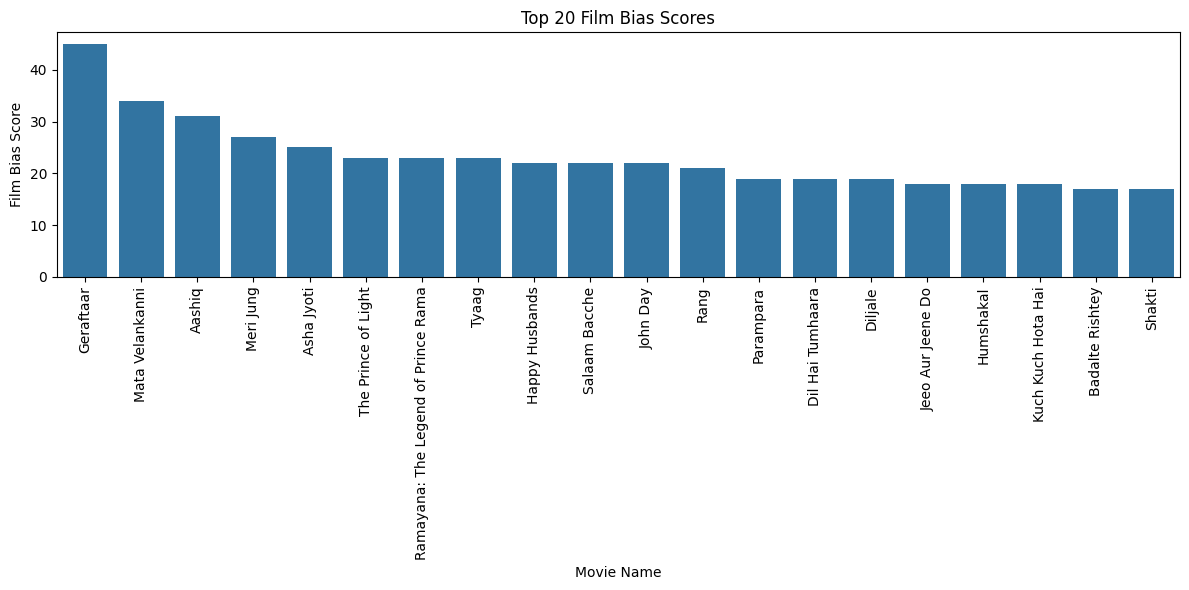


decade_bias_scores DataFrame not available or is empty, skipping decade bias plot.


In [52]:
if 'film_bias_scores' in locals() and film_bias_scores is not None and not film_bias_scores.empty:
    print("\nGenerating film bias plot...")
    plt.figure(figsize=(12, 6))
    film_bias_scores_sorted = film_bias_scores.sort_values(by='film_bias_score', ascending=False).head(20)
    sns.barplot(x='Movie Name', y='film_bias_score', data=film_bias_scores_sorted)
    plt.xticks(rotation=90)
    plt.xlabel("Movie Name")
    plt.ylabel("Film Bias Score")
    plt.title("Top 20 Film Bias Scores")
    plt.tight_layout()
    plt.show()
else:
    print("\nfilm_bias_scores DataFrame not available or is empty, skipping film bias plot.")
if decade_bias_scores is not None and not decade_bias_scores.empty:
    print("\nGenerating decade bias plot...")
    plt.figure(figsize=(10, 5))
    decade_bias_scores_sorted = decade_bias_scores.sort_values(by='Decade')
    sns.barplot(x='Decade', y='decade_bias_score', data=decade_bias_scores_sorted)
    plt.xlabel("Decade")
    plt.ylabel("Decade Bias Score")
    plt.title("Decade Bias Scores")
    plt.tight_layout()
    plt.show()
else:
    print("\ndecade_bias_scores DataFrame not available or is empty, skipping decade bias plot.")

## Remediation Suggestions

In [53]:
try:
    GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
    genai.configure(api_key=GOOGLE_API_KEY)
except userdata.SecretNotFoundError:
    print("Warning: GOOGLE_API_KEY not found in Colab secrets.")
    print("Please add it to the secrets manager under the '🔑' in the left panel.")
    genai = None
except Exception as e:
    print(f"An error occurred while configuring the Gemini API: {e}")
    genai = None
gemini_model = None
if genai is not None:
    try:
        gemini_model = genai.GenerativeModel('gemini-1.5-flash-latest')
    except Exception as e:
        print(f"Error initializing Gemini model: {e}")
        gemini_model = None
def remediate_bias(text, stereotypes):
    suggested_alternatives = []
    if not stereotypes:
        return {
            "original_text": text,
            "identified_stereotypes": [],
            "suggested_alternatives": ["No stereotypes identified, no alternatives suggested."]
        }
    if gemini_model is not None:
        prompt = f"""
        The following text excerpt from a movie plot synopsis has been identified with potential gender stereotypes.
        Original text: "{text}"
        Identified stereotypes: {', '.join(stereotypes)}
        Please provide a few alternative phrasings or suggestions to rewrite this text to reduce or eliminate these stereotypes, while preserving the original narrative intent as much as possible.
        Suggestions:
        """
        try:
            response = gemini_model.generate_content(prompt)
            gemini_suggestions = response.text.strip().split('\n')
            suggested_alternatives = [s for s in gemini_suggestions if s]
            if not suggested_alternatives:
                 suggested_alternatives.append("Gemini did not return any specific suggestions.")
        except Exception as e:
            print(f"Error calling Gemini API: {e}")
            suggested_alternatives = [f"Error generating suggestions with Gemini: {e}"]
    else:
        suggested_alternatives.append("Gemini model not initialized. Cannot generate alternatives using LLM.")
    return {
        "original_text": text,
        "identified_stereotypes": stereotypes,
        "suggested_alternatives": suggested_alternatives
    }

## Reporting

In [54]:



def generate_bias_report(movie_title, analysis_data, film_bias_scores, quantified_visual_bias_df, film_visual_bias_scores, output_filename="bias_report.pdf"):
    """
    Generates a bias report for a specific movie in PDF format, including film-level scores
    (textual and visual), flagged excerpts, character details, and remediation suggestions
    (textual and visual).

    Args:
        movie_title (str): The title of the movie for which to generate the report.
        analysis_data (pd.DataFrame): DataFrame containing detailed textual analysis results.
        film_bias_scores (pd.DataFrame): DataFrame containing film-level textual bias scores.
        quantified_visual_bias_df (pd.DataFrame): DataFrame containing detailed visual analysis and scores.
        film_visual_bias_scores (pd.DataFrame): DataFrame containing film-level visual bias scores.
        output_filename (str): The name of the output PDF file.
    """
    doc = SimpleDocTemplate(output_filename, pagesize=letter)
    Story = []
    styles = getSampleStyleSheet()

    Story.append(Paragraph(f"Bias Feedback Report for: {movie_title}", styles['h1']))
    Story.append(Spacer(1, 0.25 * inch))

    movie_text_data = analysis_data[analysis_data['Movie Name'] == movie_title].copy()

    movie_visual_data = quantified_visual_bias_df[
        quantified_visual_bias_df['Movie Name_from_image'] == movie_title
    ].copy()


    if movie_text_data.empty and movie_visual_data.empty:
        Story.append(Paragraph(f"No analysis data found for movie: {movie_title}", styles['Normal']))
        doc.build(Story)
        print(f"Report generated: {output_filename}")
        return

    film_text_score_row = film_bias_scores[film_bias_scores['Movie Name'] == movie_title]
    film_text_bias_score = int(film_text_score_row['film_bias_score'].sum()) if not film_text_score_row.empty else 0

    film_visual_score_row = film_visual_bias_scores[film_visual_bias_scores['Movie Name_from_image'] == movie_title]
    film_visual_bias_score = int(film_visual_score_row['film_visual_bias_score'].sum()) if not film_visual_score_row.empty else 0

    Story.append(Paragraph(f"Overall Textual Bias Score: {film_text_bias_score}", styles['h2']))
    Story.append(Paragraph(f"Overall Visual Bias Score: {film_visual_bias_score}", styles['h2']))
    Story.append(Spacer(1, 0.1 * inch))

    Story.append(Paragraph("Textual Bias Details:", styles['h2']))
    Story.append(Spacer(1, 0.1 * inch))

    if not movie_text_data.empty:
        for index, row in movie_text_data.iterrows():
            if 'stereotypes' in row and 'row_character_bias_score' in row:
                stereotypes = row['stereotypes']
                row_character_bias_score = row['row_character_bias_score']
                character_info_improved = row['character_info_improved'] if 'character_info_improved' in row else {}

                if isinstance(stereotypes, dict) and stereotypes and row_character_bias_score > 0:
                    relevant_text_excerpt = row['Cleaned Plot'] if 'Cleaned Plot' in row else row['Coref Plot'] if 'Coref Plot' in row else "N/A"

                    remediation_suggestions = remediate_bias(relevant_text_excerpt, list(stereotypes.keys()))

                    Story.append(Paragraph("---", styles['Normal']))
                    Story.append(Spacer(1, 0.1 * inch))
                    Story.append(Paragraph(f"<b>Text Excerpt:</b> {relevant_text_excerpt}", styles['Normal']))
                    Story.append(Paragraph(f"<b>Identified Textual Stereotypes:</b> {', '.join(stereotypes.keys())}", styles['Normal']))
                    Story.append(Paragraph(f"<b>Textual Row Bias Score:</b> {int(row_character_bias_score)}", styles['Normal']))
                    Story.append(Spacer(1, 0.05 * inch))

                    character_data = [['Character', 'Attributes', 'Gender Hints']]
                    for char, info in character_info_improved.items():
                         attributes_str = ", ".join([f"{attr_type}: {', '.join(attr_list)}" for attr_type, attr_list in info['attributes'].items() if attr_type != 'gender_hints' and attr_list])
                         gender_hints_str = ", ".join(info['attributes']['gender_hints'])
                         character_data.append([char, attributes_str, gender_hints_str])

                    if len(character_data) > 1:
                        table = Table(character_data)
                        table.setStyle(TableStyle([
                            ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
                            ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
                            ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                            ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                            ('FONTSIZE', (0, 0), (-1, 0), 10),
                            ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                            ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
                            ('GRID', (0, 0), (-1, -1), 1, colors.black)
                        ]))
                        Story.append(table)
                        Story.append(Spacer(1, 0.1 * inch))


                    Story.append(Paragraph("<b>Suggested Textual Alternatives:</b>", styles['Normal']))
                    for suggestion in remediation_suggestions['suggested_alternatives']:
                        Story.append(Paragraph(f"- {suggestion}", styles['Normal']))
                    Story.append(Spacer(1, 0.25 * inch))
    else:
        Story.append(Paragraph("No significant textual bias detected for this movie.", styles['Normal']))
        Story.append(Spacer(1, 0.25 * inch))

    Story.append(Paragraph("Visual Bias Details (from Posters):", styles['h2']))
    Story.append(Spacer(1, 0.1 * inch))

    if not movie_visual_data.empty:
        for index, row in movie_visual_data.iterrows():
            image_filename = row.get('image_filename', 'Unknown Image')
            total_image_bias_score = row.get('total_image_bias_score', 0)
            character_bias_details = row.get('character_bias_details', [])

            if total_image_bias_score > 0 and character_bias_details:
                Story.append(Paragraph("---", styles['Normal']))
                Story.append(Spacer(1, 0.1 * inch))
                Story.append(Paragraph(f"<b>Poster Image:</b> {image_filename}", styles['Normal']))
                Story.append(Paragraph(f"<b>Visual Image Bias Score:</b> {int(total_image_bias_score)}", styles['Normal']))
                Story.append(Spacer(1, 0.05 * inch))

                visual_character_data = [['Character ID', 'Visual Bias Score', 'Stereotypes Breakdown']]
                for char_detail in character_bias_details:
                     char_id = char_detail.get('character_id', 'Unknown')
                     bias_score = char_detail.get('character_bias_score', 0)
                     stereotypes_breakdown = char_detail.get('stereotypes_breakdown', {})
                     stereotypes_str = ", ".join([f"{st} ({score})" for st, score in stereotypes_breakdown.items()])
                     visual_character_data.append([char_id, int(bias_score), stereotypes_str])

                if len(visual_character_data) > 1:
                    table = Table(visual_character_data)
                    table.setStyle(TableStyle([
                        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
                        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
                        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                        ('FONTSIZE', (0, 0), (-1, 0), 10),
                        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                        ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
                        ('GRID', (0, 0), (-1, -1), 1, colors.black)
                    ]))
                    Story.append(table)
                    Story.append(Spacer(1, 0.1 * inch))

                visual_remediation_suggestions = suggest_poster_remediation(
                    image_filename,
                    character_bias_details,
                    gemini_model
                )
                Story.append(Paragraph("<b>Suggested Visual Remediation:</b>", styles['Normal']))
                Story.append(Paragraph(visual_remediation_suggestions, styles['Normal']))
                Story.append(Spacer(1, 0.25 * inch))

    else:
        Story.append(Paragraph("No significant visual bias detected in posters for this movie.", styles['Normal']))
        Story.append(Spacer(1, 0.25 * inch))


    try:
        doc.build(Story)
        print(f"\nBias report generated successfully as {output_filename}")
    except Exception as e:
        print(f"\nError generating PDF report: {e}")


## Implementation and Result

In [56]:
if not analysis_data.empty and 'film_bias_scores' in locals() and film_bias_scores is not None and not film_bias_scores.empty and \
   'quantified_visual_bias_df' in locals() and not quantified_visual_bias_df.empty and \
   'film_visual_bias_scores' in locals() and film_visual_bias_scores is not None and not film_visual_bias_scores.empty and \
   'gemini_model' in locals() and gemini_model is not None:
    sample_movie_title = None
    biased_text_movies = film_bias_scores[film_bias_scores['film_bias_score'] > 0]
    if not biased_text_movies.empty:
        sample_movie_title = biased_text_movies.iloc[0]['Movie Name']
    if sample_movie_title is None and not film_visual_bias_scores.empty and 'film_visual_bias_score' in film_visual_bias_scores.columns:
         biased_visual_movies = film_visual_bias_scores[film_visual_bias_scores['film_visual_bias_score'] > 0]
         if not biased_visual_movies.empty:
             if 'Movie Name_from_image' in biased_visual_movies.columns:
                  sample_movie_title = biased_visual_movies.iloc[0]['Movie Name_from_image']
             else:
                 print("Could not determine original movie name for visual bias, skipping report.")
    if sample_movie_title:
        print(f"\nGenerating bias report for movie: {sample_movie_title}")
        generate_bias_report(
            sample_movie_title,
            analysis_data,
            film_bias_scores,
            quantified_visual_bias_df,
            film_visual_bias_scores,
            output_filename=f"{sample_movie_title}_bias_report.pdf"
        )
    else:
        print("\nCould not find a suitable movie title to generate a report.")
else:
    print("\nNecessary dataframes (analysis_data, film_bias_scores, quantified_visual_bias_df, film_visual_bias_scores) or Gemini model not available or are empty, cannot generate sample report.")


Could not find a movie with both textual and visual bias. Using first movie with textual bias: 13B

Generating bias report for movie: 13B

Bias report generated successfully as 13B_bias_report.pdf
